In [2]:
# import packages

# data processing
import pandas as pd
import numpy as np
from datetime import timedelta, datetime


import re

# data visualization
import plotly.graph_objs as go
from plotly.graph_objs import Bar, Layout
from plotly import offline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 10)

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

# IPython
from IPython.display import IFrame

from sklearn.feature_selection import mutual_info_classif

%matplotlib inline

In [3]:
train = pd.read_csv('F:/BaiduNetdiskDownload/WhaleDataScienceProject-master/train.csv')
test = pd.read_csv('F:/BaiduNetdiskDownload/WhaleDataScienceProject-master/test.csv')

In [4]:
fullset = pd.concat([train,test],ignore_index=True)

In [8]:
train_imp = pd.read_csv("train_imp.csv",index_col=0)

### Discrete Feature Analysis

Let's take a look at the contribution degree of each discrete feature for target=1. You may be wondering how to quantify the contribution degree? What I mean is to look at the proportion of target=1 in each class of the discrete variable.

In [6]:
def meta(train,test,missing_values = -1,cols_ignore_missing = []):
    
    df = pd.concat([train,test]).reset_index(drop=True).fillna('未知')
    data = []
    for col in df.columns:
        # define role
        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'feature'
        
        # define category
        if 'ind' in col:
            category = 'individual'
        elif 'car' in col:
            category = 'car'
        elif 'calc' in col:
            category = 'calculated'
        elif 'reg' in col:
            category = 'region'
        else:
            category = 'other'
        
        
        # define level of measurements
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col[-3:] or col == 'id':
            level = 'nominal'
        elif df[col].dtype == 'float64' and df[col].replace(missing_values,np.nan).max()-df[col].replace(missing_values,np.nan).min() > 1:
            level = 'interval'
        elif df[col].dtype == 'float64' and df[col].replace(missing_values,np.nan).max()-df[col].replace(missing_values,np.nan).min() <= 1:
            level = 'ratio'
        elif df[col].dtype == 'int64':
            level = 'ordinal'
            
        # define data type
        dtype = df[col].dtype
        
        # define unique
        if col == 'id' or df[col].dtype == 'float64':
            uniq = 'Ignore'
        else:
            if col in cols_ignore_missing:
                uniq = df[col].nunique()
            else:
                uniq = df[col].replace({missing_values:np.nan}).nunique()
                
        # define cardinality
        if uniq == 'Ignore':
            cardinality = 'Ignore'
        elif uniq <= 10:
            cardinality = 'Low Cardinality'
        elif uniq <= 30:
            cardinality = 'Medium Cardinality'
        else:
            cardinality = 'High Cardinality'
        
        # def missing
        if col in cols_ignore_missing:
            missing = 0
        else:
            missing = sum(df[col] == missing_values)
            
        # def missing percent
        missing_percent = f'{missing}({round(missing*100/len(df),2)}%)'
        
        # def imputation
        if missing > df.shape[0]*0.4:
            imputation = 'remove'
        elif missing > 0:
            if level == 'binary' or level == 'nominal':
                imputation = ('mode')
            if level == 'ordinal':
                imputation = ('mode','median')
            if level == 'interval' or level == 'ratio':
                imputation = ('mode','median','mean')        
        else:
            imputation = "No Missing"
            
        # def keep
        keep = True
        if col  == 'id' or imputation == 'remove':
            keep = False
        col_dict = {
            'colname': col,
            'role': role,
            'category': category,
            'level': level,
            'dtype': dtype,
            'cardinality': uniq,
            'cardinality_level':cardinality,
            'missing': missing,
            'missing_percent': missing_percent,
            'imputation':imputation,
            'keep': keep,
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=list(col_dict.keys()))
    meta.set_index('colname', inplace=True)
    
    return meta

In [7]:
metadata = meta(train,test)

#### Norminal

In [11]:
cat_cols = metadata[(metadata.level == 'nominal') & (metadata.keep)].index

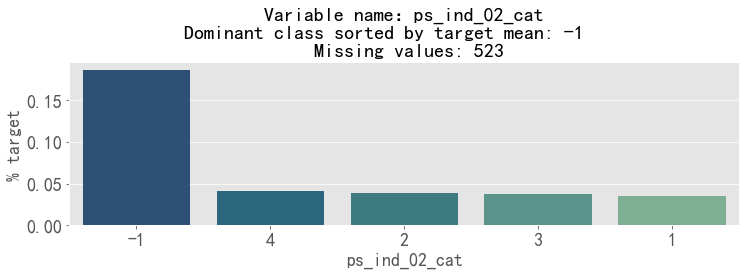

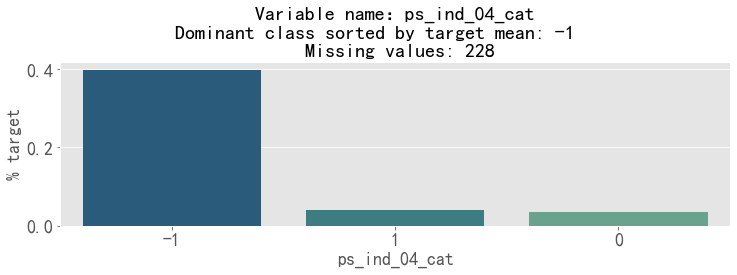

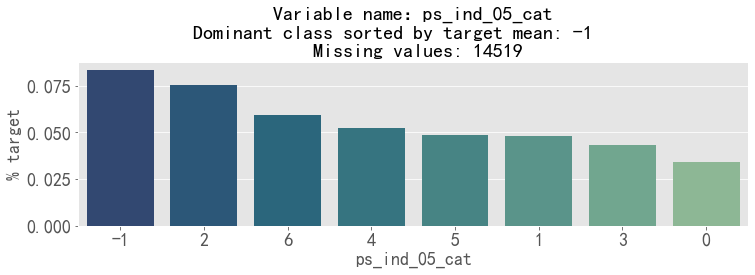

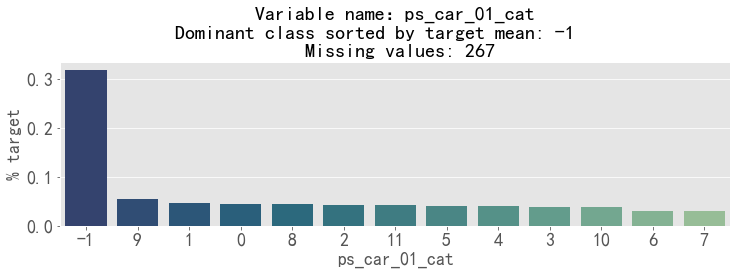

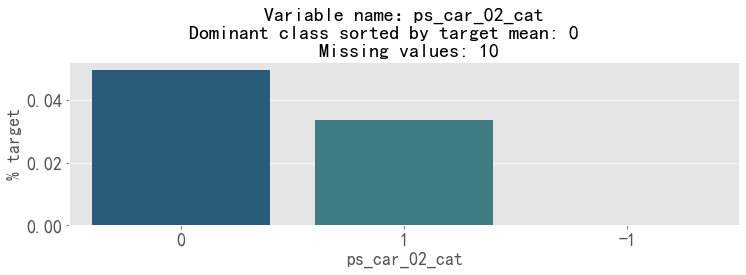

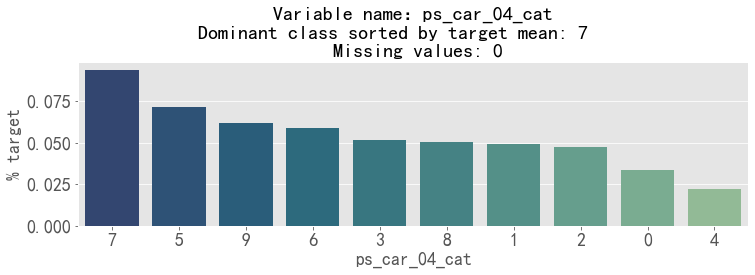

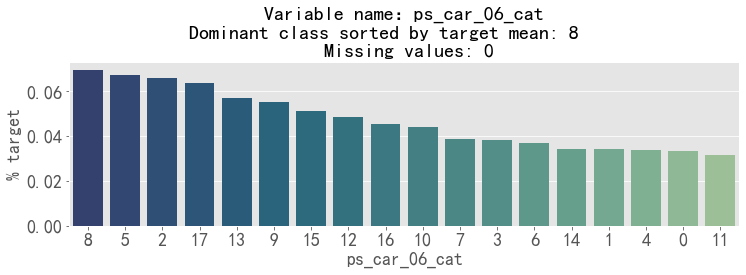

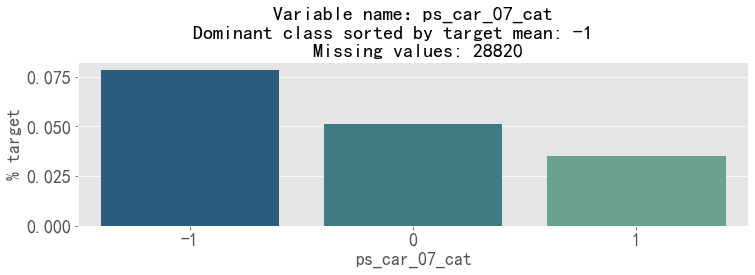

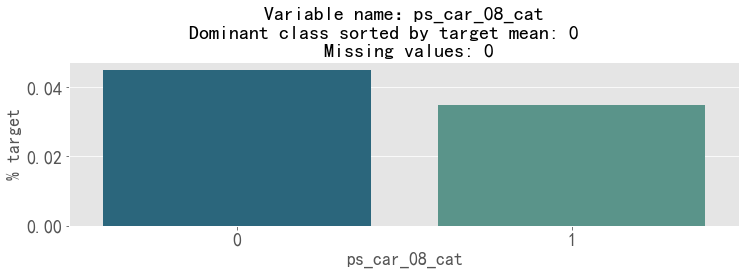

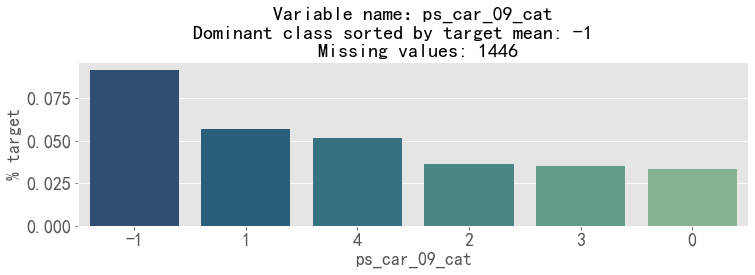

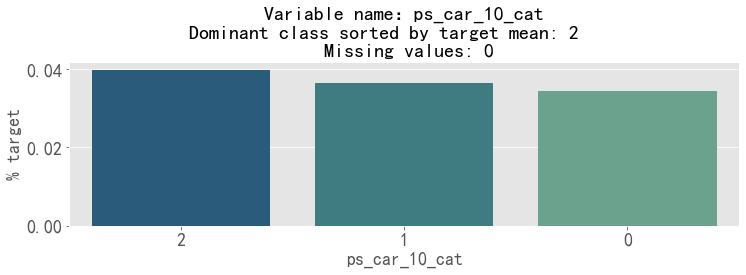

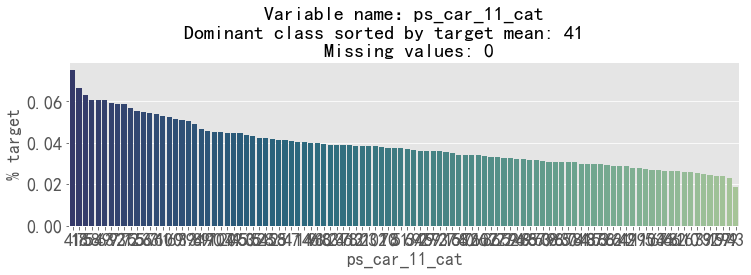

In [12]:
for col in cat_cols:
    fig, ax = plt.subplots(figsize=(12,3))
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[col, 'target']].groupby([col],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar chart，from lowest to highest according ot traget mean.
    sns.barplot(ax=ax, x=col, y='target', data=cat_perc, order=cat_perc[col],palette = 'crest_r')
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(col, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.title(f"Variable name：{col}\n Dominant class sorted by target mean: {cat_perc[col].iloc[0]} \
    \n Missing values: {metadata.loc[col]['missing']}", fontsize = 20)
    plt.show();

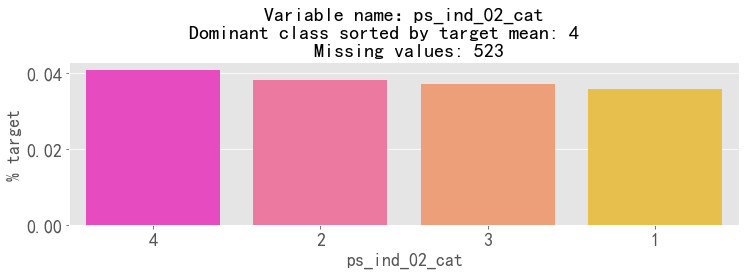

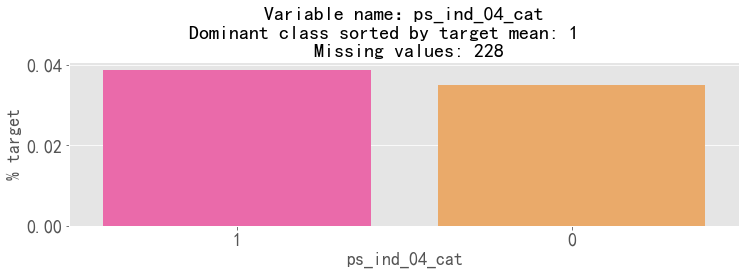

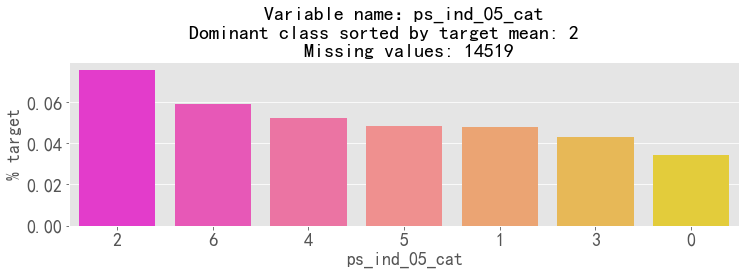

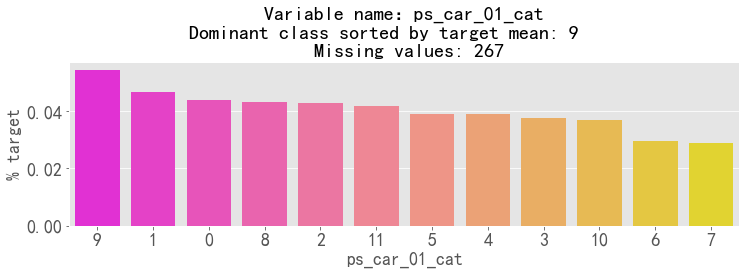

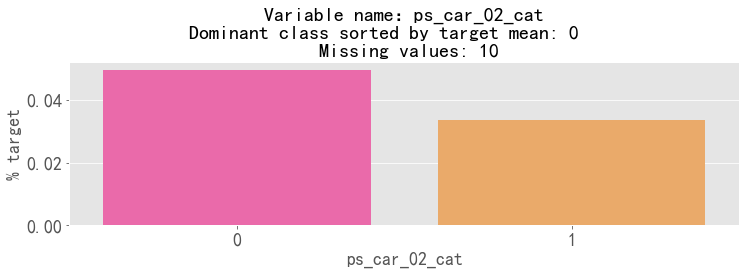

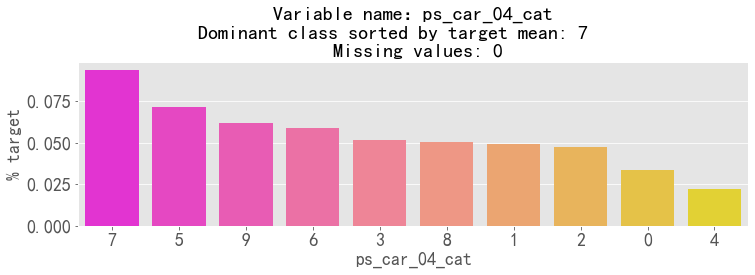

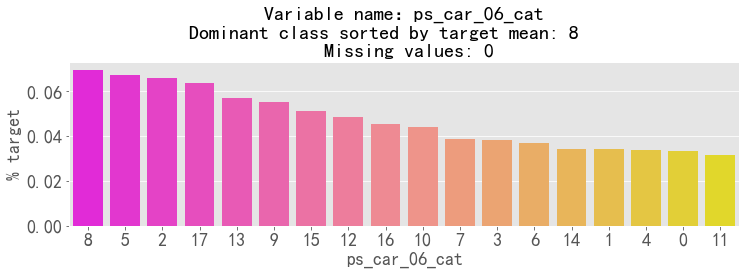

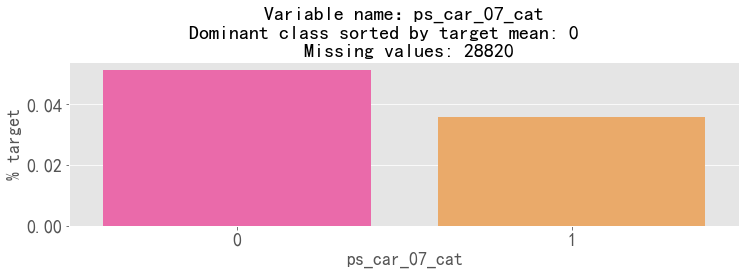

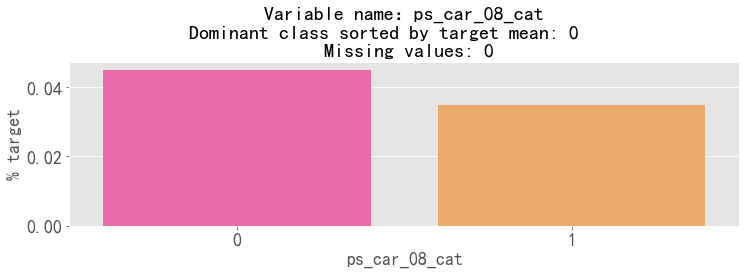

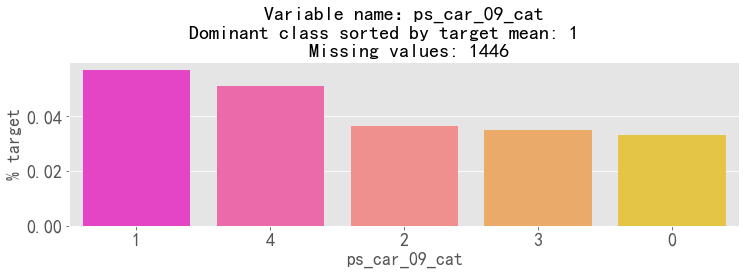

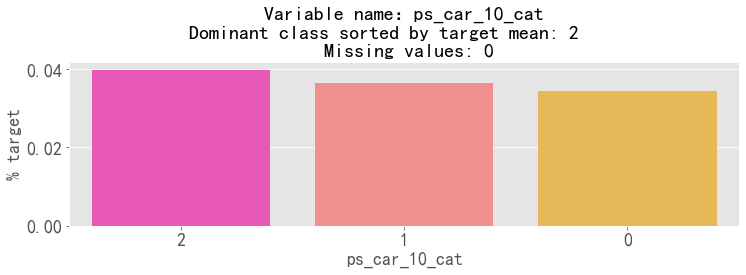

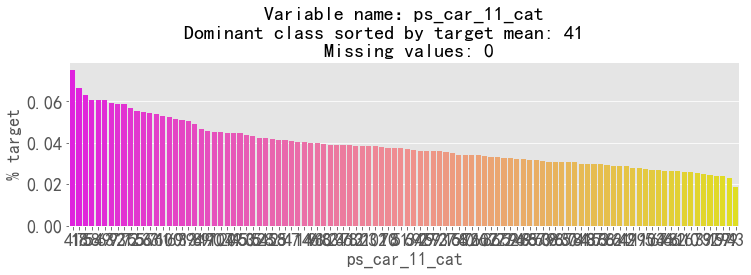

In [13]:
for col in cat_cols:
    fig, ax = plt.subplots(figsize=(12,3))
    # Calculate the percentage of target=1 per category value
    cat_perc = train_imp[[col, 'target']].groupby([col],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # 柱形图，根据target mean从大到小排列。
    sns.barplot(ax=ax, x=col, y='target', data=cat_perc, order=cat_perc[col],palette = 'spring')
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(col, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.title(f"Variable name：{col}\n Dominant class sorted by target mean: {cat_perc[col].iloc[0]} \
    \n Missing values: {metadata.loc[col]['missing']}", fontsize = 20)
    plt.show();

The graph above uses data without filling in missing values, while the bottom one is filled in. This graph represents the proportion of each category related to target=1, that is, the proportion of whether or not to claim, for example, ps_car_07_cat, in the first batch of code, in the graph obtained, when it is equal to -1, the proportion of target=1 is the highest, more than 25%, other variables are also similar situations, except for the last two, because the number of missing values is too small. We should use inverse_transform to invert the previously imputed discrete variables, retain the -1 class as our research category, and update our metadata. The last two missing values only have a few data, we continue to fill in with mode.

In [14]:
reverse_trans_cols = [
 'ps_car_07_cat',
 'ps_ind_05_cat',
 'ps_car_09_cat',
 'ps_ind_02_cat',
 'ps_car_01_cat',
 'ps_ind_04_cat',
]

In [15]:
train_imp[reverse_trans_cols] = train[reverse_trans_cols]

In [5]:
(train_imp.ps_car_11_cat.value_counts()/train_imp.shape[0]).plot(kind='bar',figsize = [30,10])
plt.tick_params(axis='y', which='major', labelsize=20)

NameError: name 'train_imp' is not defined

#### Binary

In [17]:
bin_cols = metadata[(metadata.level == 'binary') & (metadata.keep)].index

In [19]:
zero_list = []
one_list = []
for col in bin_cols:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [20]:
trace1 = go.Bar(
    x=bin_cols,
    y=zero_list ,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_cols,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables including TARGET'
)

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='stacked-bar')

Here we observe that there are 4 features : ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin which are completely dominated by zeros. This begs the question of whether these features are useful at all as they do not contain much information about the other class vis-a-vis the target.

#### Ordinal

In [21]:
ord_cols = metadata[(metadata.level == 'ordinal') & (metadata.keep)].index

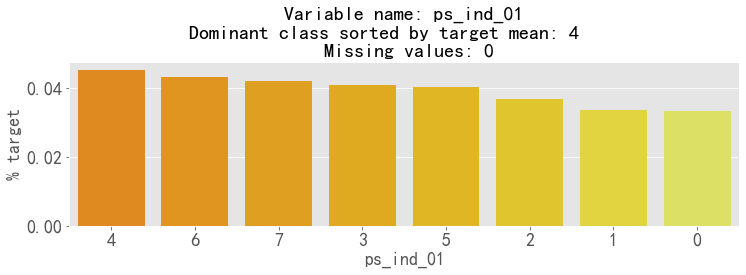

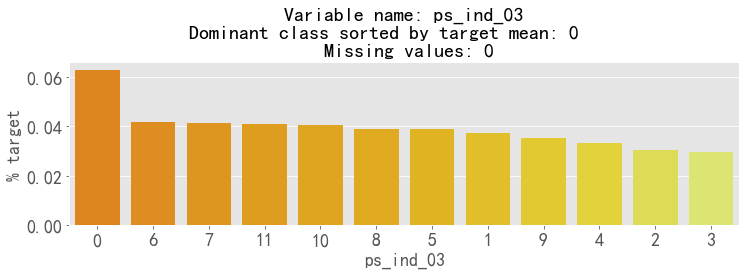

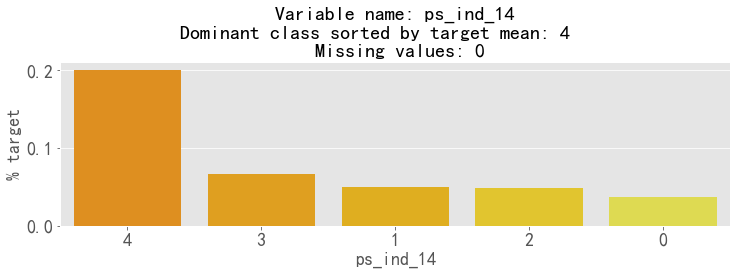

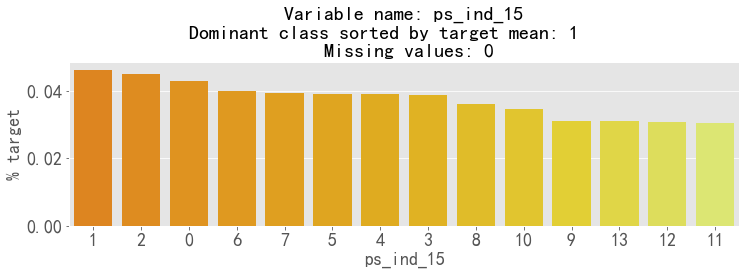

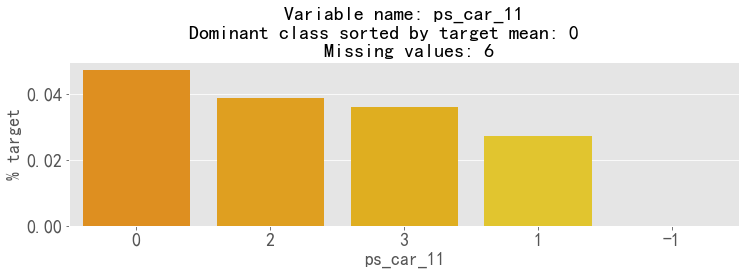

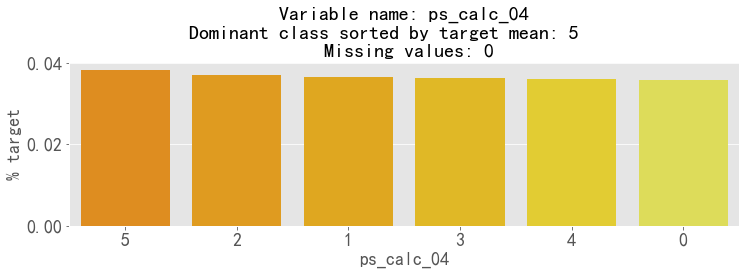

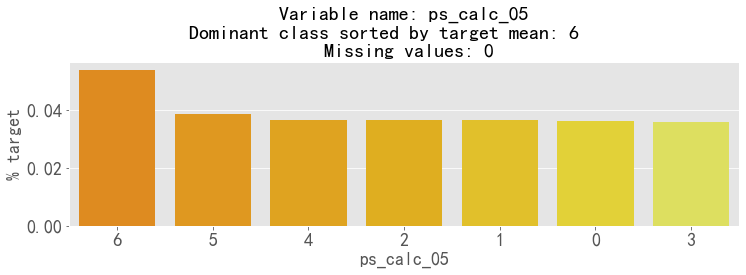

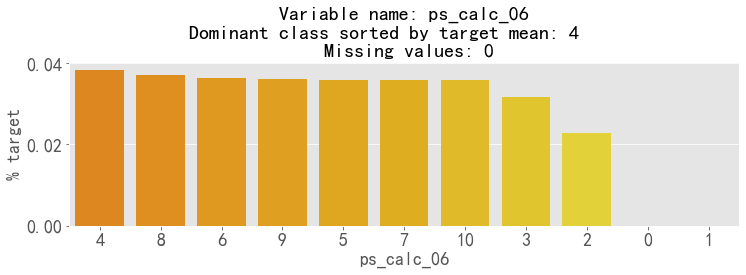

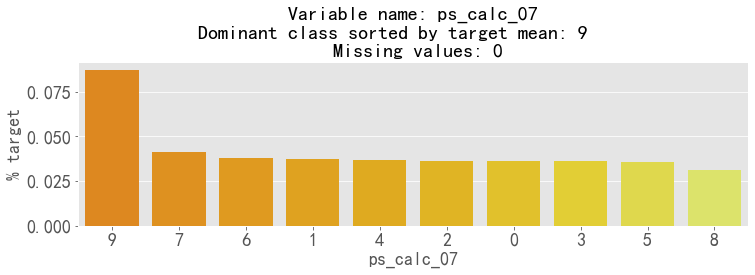

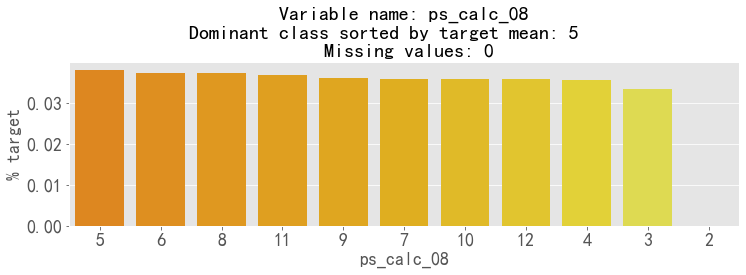

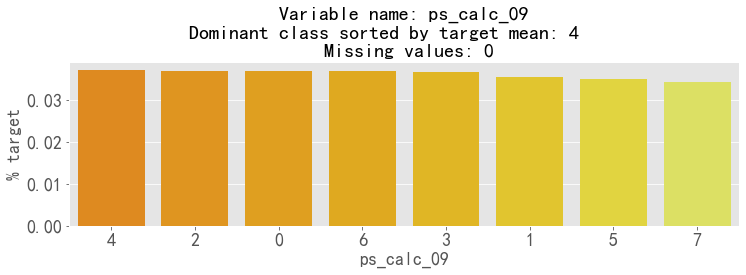

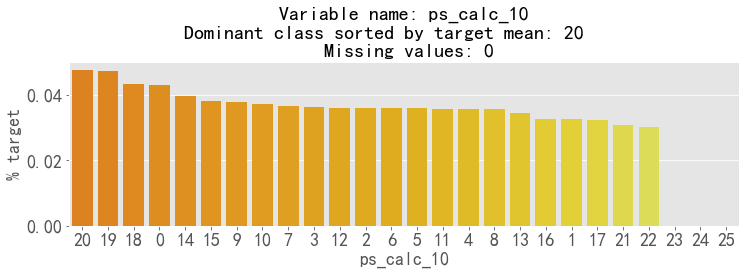

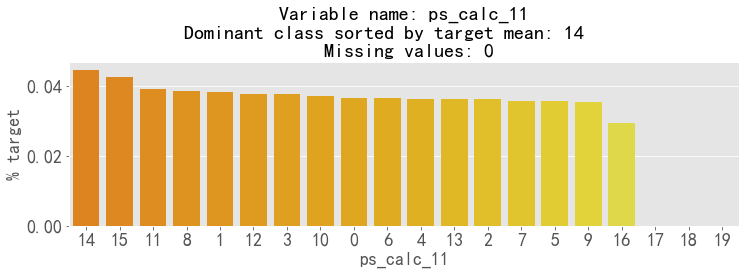

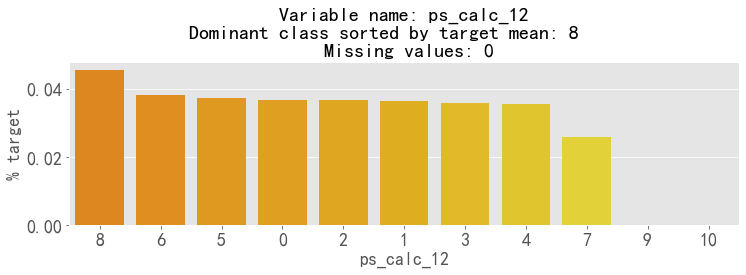

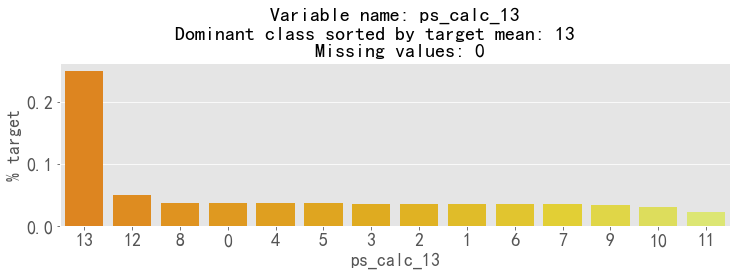

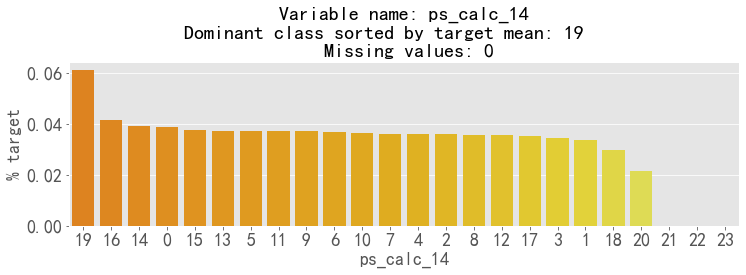

In [22]:
for col in ord_cols:
    fig, ax = plt.subplots(figsize=(12,3))
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[col, 'target']].groupby([col],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # 柱形图，根据target mean从大到小排列。
    sns.barplot(ax=ax, x=col, y='target', data=cat_perc, order=cat_perc[col],palette = 'Wistia_r')
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(col, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.title(f"Variable name: {col}\n Dominant class sorted by target mean: {cat_perc[col].iloc[0]} \
    \n Missing values: {metadata.loc[col]['missing']}", fontsize = 20)
    plt.show();

### Continuous Variable Analysis

##### Correlation Analysis

In [23]:
conti_cols = metadata[(metadata.level.isin(['ratio','interval'])) & (metadata.keep)].index

In [24]:
conti_cols

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03'],
      dtype='object', name='colname')

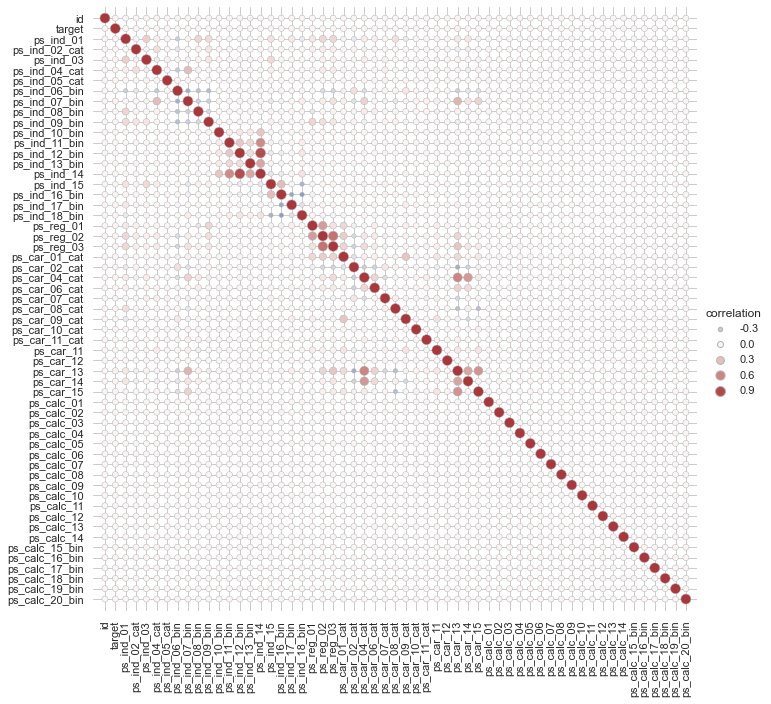

In [25]:
sns.set_theme(style="whitegrid")
corr_mat = train_imp.corr().stack().reset_index(name="correlation")

# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(20, 100), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

<AxesSubplot:>

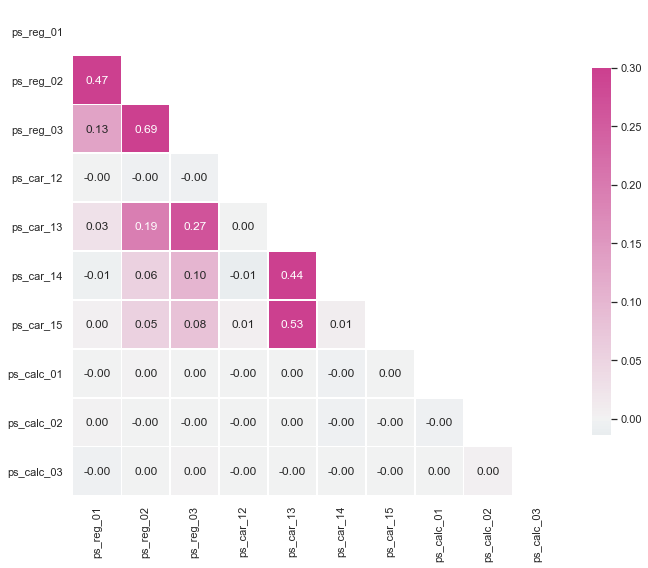

In [26]:
# Generate a mask for the upper triangle

corr_mat = train_imp[conti_cols].corr()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, -20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75},annot=True,fmt='.2f')

There are a strong correlations between the variables:

ps_reg_02 and ps_reg_03 (0.69)
ps_car_12 and ps_car_13 (0.67)
ps_car_12 and ps_car_14 (0.58)
ps_car_13 and ps_car_15 (0.53)
ps_reg_01 and ps_reg_02 (0.47)

#### Regression Analysis

In [27]:
trn_sample = train_imp.sample(2000)

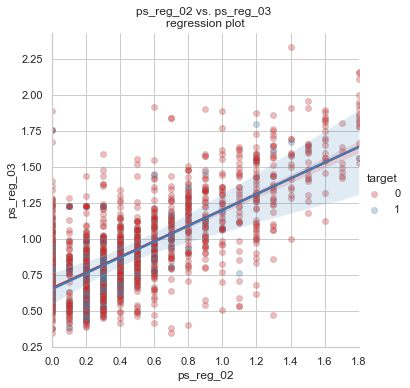

In [28]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=trn_sample, hue='target', 
           palette='Set1', height = 5, scatter_kws={'alpha':0.3,'edgecolor':'gray'}).set(title='ps_reg_02 vs. ps_reg_03 \nregression plot')

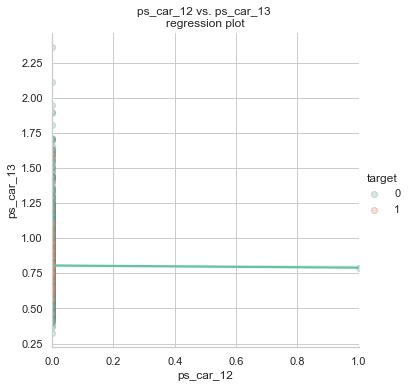

In [29]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=trn_sample, hue='target', 
           palette='Set2', height = 5, scatter_kws={'alpha':0.3,'edgecolor':'gray'}).set(title='ps_car_12 vs. ps_car_13 \nregression plot')

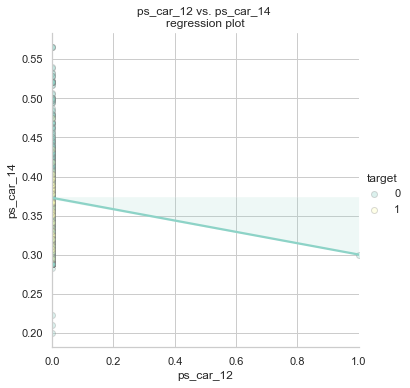

In [30]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=trn_sample, hue='target', 
           palette='Set3', height = 5, scatter_kws={'alpha':0.3,'edgecolor':'gray'}).set(title='ps_car_12 vs. ps_car_14 \nregression plot')

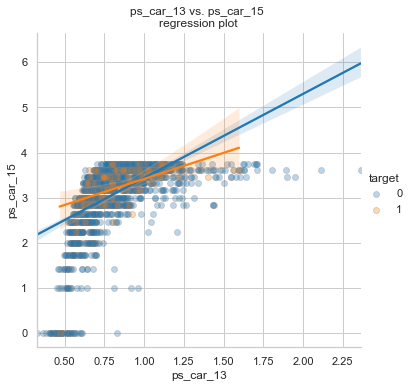

In [31]:
sns.lmplot(x='ps_car_13', y='ps_car_15', data=trn_sample, hue='target', 
           palette='tab10', height = 5, scatter_kws={'alpha':0.3,'edgecolor':'gray'}).set(title='ps_car_13 vs. ps_car_15 \nregression plot')

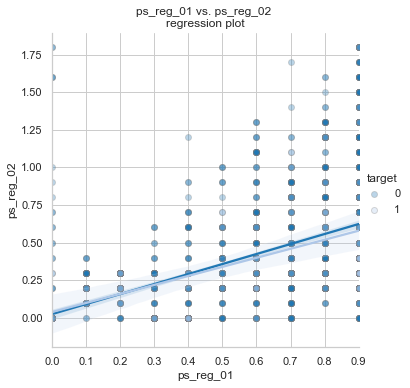

In [32]:
sns.lmplot(x='ps_reg_01', y='ps_reg_02', data=trn_sample, hue='target', 
           palette='tab20', height = 5, scatter_kws={'alpha':0.3,'edgecolor':'gray'}).set(title='ps_reg_01 vs. ps_reg_02 \nregression plot')

### Feature Importance Analysis

In [34]:
from xgboost import XGBClassifier
from xgboost import plot_importance
plt.figure(figsize = [100,20])

X = train_imp.drop(['id', 'target'], axis=1)
y = train_imp.target

model = XGBClassifier()

model.fit(X, y)
# plot feature importance

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

<Figure size 7200x1440 with 0 Axes>

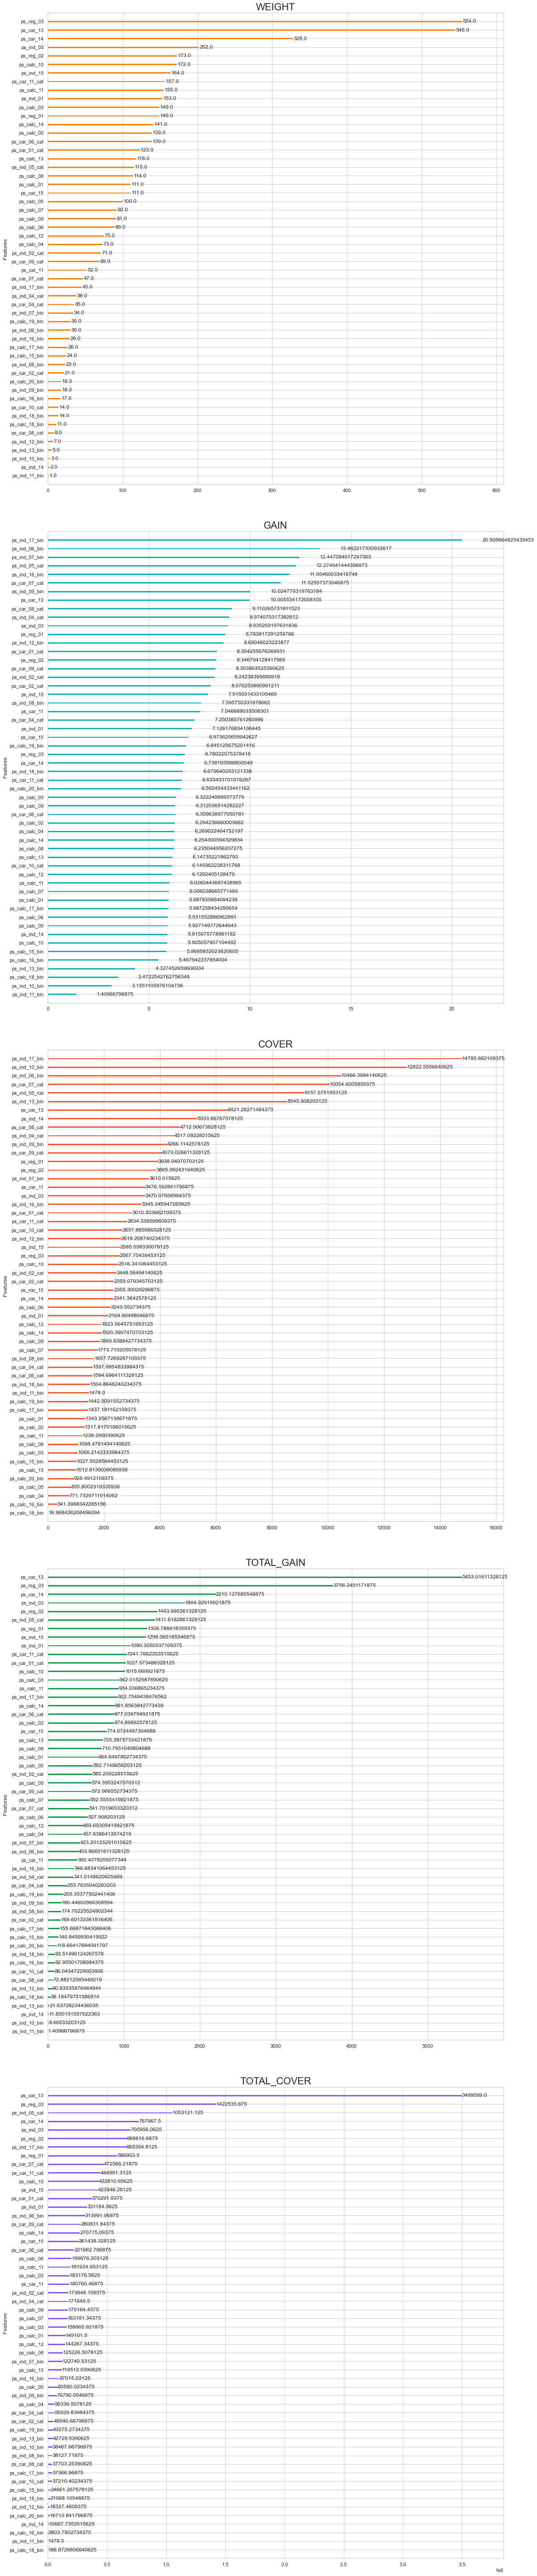

In [35]:
# define subplot grid
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15, 80))
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
# loop through tickers and axes
colors = ['#ff7f01','#08aebd','#fc5531','#139948','#8950fe']
for ty, ax, color in zip(types, axs.ravel(), colors):
    # filter df for ticker and plot on specified axes
    plot_importance(ax = ax, booster = model,importance_type=ty, color = color)

    # chart formatting
    ax.set_title(ty.upper(),fontsize = 22)
    ax.set_xlabel("")

plt.show()

- 【gain】增益意味着相应特征对模型的相对贡献，通过获取模型中每棵树的每个特征的贡献来计算。与另一个特征相比，该指标的值越高意味着它对于生成预测更重要。
- 【Coverage】是指与该特征相关的观察的相对数量。例如，如果您有 100 个观测值，4 个特征和 3 棵树，假设在 tree1、tree2 和 tree3 中分别使用 feature1 来决定 10、5 和 2 个观测值的叶子节点；那么该指标将将此特征的覆盖率计为 10+5+2 = 17 个观察值。这将针对所有 4 个功能进行计算，并且覆盖率将 17 表示为所有功能的覆盖率指标的百分比。
- 【weights】是表示特定特征在模型树中出现的相对次数的百分比。在上面的例子中，如果feature1出现2次分裂，则tree1、tree2和tree3各有1次分裂和3次分裂；那么特征 1 的权重将为 2+1+3 = 6。特征 1 的频率计算为其权重占所有特征权重的百​​分比。


> 增益是解释每个特征的相对重要性最相关的属性。
“增益”是特征为其所在分支带来的准确性提高。这个想法是，在将特征 X 上的新拆分添加到分支之前，有一些错误分类的元素，在此特征上添加拆分后，有两个新分支，每个分支都更准确（一个分支说如果你的观察是在这个分支上，那么它应该被归类为 1，而另一个分支则完全相反）。
“覆盖率”衡量一个特征所涉及的观察的相对数量。

### Mutual information 

Mutual information is another useful tool to measure the reduction of the uncertainty of the system between the target variable and the corresponding feature.

For classification problems, we can conveniently call Sklearn's mutual_info_classif method which measures the dependency between two random variables and ranges from zero. This therefore will help give us an idea of how much information from the target may be contained within the features.

In [36]:
%%time
mf = mutual_info_classif(train_imp.drop(['id','target'],axis=1).values,
                         train_imp.target.values,
                         n_neighbors=30, random_state=2022)
print(mf)

[1.13688315e-03 4.22158074e-03 1.35599884e-03 1.68686989e-03
 8.57707895e-04 1.86228440e-03 1.12560973e-03 2.77409873e-04
 4.06129362e-04 0.00000000e+00 1.14051723e-05 7.66921627e-05
 0.00000000e+00 1.12701163e-05 1.24501323e-03 4.49947066e-03
 5.92141362e-04 2.36087711e-04 1.34802166e-03 9.28019750e-04
 5.18843733e-04 2.80119096e-03 6.64504597e-03 7.93398089e-04
 1.53250383e-03 8.38246069e-03 6.60925418e-03 5.06933218e-03
 9.00388241e-03 1.44670132e-03 3.91695305e-03 0.00000000e+00
 1.84021357e-03 9.77655896e-04 1.26728143e-03 3.82313257e-04
 3.90869701e-04 2.84671759e-04 1.96475285e-03 2.05495176e-03
 1.96014168e-03 1.60294717e-03 1.88351358e-03 1.79755088e-03
 9.60430682e-04 9.10600275e-04 1.74713733e-03 1.38065000e-03
 8.71062322e-04 1.20886246e-04 3.56145372e-03 2.70045648e-03
 7.07345176e-04 1.10377568e-03 9.43819366e-05]
Wall time: 6min 58s


In [37]:
threshold = 10
high_score_features = []
high_score = []
for score, f_name in sorted(zip(mf, train_imp.drop(['id','target'],axis=1).columns), reverse=True)[:threshold]:
    print(f_name, score)
    high_score_features.append(f_name)
    high_score.append(score)

ps_car_10_cat 0.009003882411455333
ps_car_07_cat 0.008382460694422278
ps_car_02_cat 0.006645045972727637
ps_car_08_cat 0.006609254183864266
ps_car_09_cat 0.005069332176625085
ps_ind_16_bin 0.0044994706649483796
ps_ind_02_cat 0.00422158074290202
ps_car_11 0.003916953051236849
ps_calc_16_bin 0.00356145371805372
ps_car_01_cat 0.0028011909644849453


In [1]:
sns.barplot(y = high_score_features, x = high_score, palette = 'crest')

NameError: name 'sns' is not defined